# Homework NLP 2019/2020: Named Entity Recognition


## Training phase

### Link Colab to Google Drive

In [1]:
GDRIVE_DIR = '/content/gdrive'
GDRIVE_HOME_DIR = f'{GDRIVE_DIR}/My Drive'
GDRIVE_HW_DIR = f'{GDRIVE_HOME_DIR}/Colab Notebooks/nlp2020-hw1'
GDRIVE_DATA_DIR = f'{GDRIVE_HW_DIR}/hw1/stud'

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

%cd $GDRIVE_DATA_DIR

TRAIN_PATH = '../../data/train.tsv'
DEV_PATH = '../../data/dev.tsv'
PRETRAINED_PATH = '../../model/pretrained'
FAST_TEXT_PATH = f'{PRETRAINED_PATH}/fast_text/cc.en.300.vec'
WEIGHTS_PATH = f'{GDRIVE_HW_DIR}/model/weights.pt'
PARAMS_PATH = f'{GDRIVE_HW_DIR}/model/params.json'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/nlp2020-hw1/hw1/stud


### Import dependecies

In [2]:
from dataset import Dataset
from model import LSTM_CRF
from trainer import Trainer
from utils import PretrainedVec, save_params
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt   

torch.manual_seed(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Preparation
Define the train dataset and the dev dataset to train and evaluate the model,
respectively, and initialize pretrained embeddings

In [3]:
BS = 256

train_dataset = Dataset(TRAIN_PATH, train=True, min_frequency=0)
train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
vocabulary = train_dataset.vocab
labels_vocabulary = train_dataset.labels_vocab
dev_dataset = Dataset(DEV_PATH, vocab=vocabulary, labels_vocab=labels_vocabulary)
dev_dataloader = DataLoader(dev_dataset, batch_size=BS*2)

embeddings = PretrainedVec(FAST_TEXT_PATH, vocabulary.wtoi)
pretrained_embeddings = embeddings.pretrained
embedding_dim = embeddings.dim


initialised embeddings 90324
random initialised embeddings 10519


### Model Definition

In [0]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

params = {'vocabulary':vocabulary.wtoi, 
          'embedding_dim':embedding_dim,
          'hidden_dim':128,
          'labels_vocabulary':labels_vocabulary.itow,
          'bidirectional':True,
          'num_layers':1,
          'dropout':0.5,
          'embeddings':pretrained_embeddings,
          'clip':2.0}

model = LSTM_CRF(params)
opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)

### Train the model

In [5]:
trainer = Trainer(model, opt, device)
trainer.train(train_dataloader, dev_dataloader, epochs=10)

Training ...



	[E:  1] train loss = 3.3652
	[E:  1] valid loss = 1.5963



	[E:  2] train loss = 1.1467
	[E:  2] valid loss = 1.5394



	[E:  3] train loss = 0.9680
	[E:  3] valid loss = 1.5708



	[E:  4] train loss = 0.9156
	[E:  4] valid loss = 1.5446



	[E:  5] train loss = 0.8888
	[E:  5] valid loss = 1.6099



	[E:  6] train loss = 0.8777
	[E:  6] valid loss = 1.6219



	[E:  7] train loss = 0.8702
	[E:  7] valid loss = 1.6570



	[E:  8] train loss = 0.8676
	[E:  8] valid loss = 1.7362



	[E:  9] train loss = 0.8571
	[E:  9] valid loss = 1.7488



	[E: 10] train loss = 0.8549
	[E: 10] valid loss = 1.7870
Validation loss = 1.786992356694978
... Done!


1.161173112816213

#### Save the parameters of the model and the weights of the trained model

In [0]:
torch.save(model.state_dict(), WEIGHTS_PATH)
save_params(params, PARAMS_PATH)

### Model Evaluation

#### Classification Report on dev dataset

In [7]:
classification_report, cm = trainer.evaluate(dev_dataloader, labels_vocabulary.wtoi)
print(classification_report)

Evaluating ...



              precision    recall  f1-score   support

         PER       0.92      0.89      0.90     14396
         LOC       0.86      0.80      0.83     12359
           O       0.99      0.99      0.99    315809
         ORG       0.82      0.73      0.77      9043

    accuracy                           0.97    351607
   macro avg       0.90      0.85      0.87    351607
weighted avg       0.97      0.97      0.97    351607



#### Confusion Matrix as heatmap

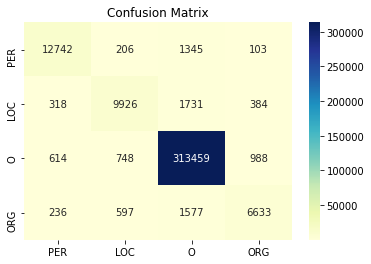

In [8]:
fig = plt.subplot()
sns.heatmap(cm, annot=True, ax=fig, fmt='d', cmap='YlGnBu');

fig.set_title('Confusion Matrix')
labels_names = [label for label in labels_vocabulary.wtoi.keys()][1:]
fig.xaxis.set_ticklabels(labels_names)
fig.yaxis.set_ticklabels(labels_names)
fig.get_figure().show()

In [0]:
fig.get_figure().savefig('heatmap.png')